In [2]:
import requests
from tqdm import tqdm_notebook as tqdm
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime

In [34]:
%matplotlib inline

In [35]:
TOKEN = r'd46da9b4388836c29c2728dcc7cd1dac63de131d'
def gh_request(url, *args, **kwargs):
    BASE = r'https://api.github.com'
    r = requests.get(BASE + url, *args, **kwargs)
    if r.status_code != 200 and not int(r.headers['X-RateLimit-Remaining']):
        reset = datetime.fromtimestamp(int(r.headers['X-RateLimit-Reset']))
        raise requests.HTTPError('Rate limit exceeded! Blocked until {}'.format(reset))
    r.raise_for_status()
    return r

In [5]:
def repos(owner):
    return gh_request('/users/{}/repos'.format(owner)).json()

def views_and_clones(owner, repo, **kw):
    views = gh_request('/repos/{}/{}/traffic/views'.format(owner, repo), **kw).json()
    clones = gh_request('/repos/{}/{}/traffic/clones'.format(owner, repo), **kw).json()
    releases = gh_request('/repos/{}/{}/releases'.format(owner, repo)).json()
    downloads = 0
    for release in releases:
        for asset in release['assets']:
            downloads += asset['download_count']
    return views['count'], clones['count'], downloads

def anaconda_downloads(owner, package, **kw):
    r = requests.get('https://api.anaconda.org/package/{}/{}'.format(owner, package))
    if r.status_code != 200:
        return 0
    downloads = 0
    for f in r.json()['files']:
        downloads += f['ndownloads']
    return downloads

def stats(owner, **kw):
    data = {}
    for repo in tqdm(repos(owner)):
        repo_owner = repo['owner']['login']
        repo_name = repo['name']
        stars = repo['stargazers_count']
        forks = repo['forks_count']
        anaconda_dl = anaconda_downloads(repo_owner, repo_name)
        views, clones, gh_downloads = views_and_clones(repo_owner, repo_name, **kw)
        data[repo_name] = {
            'GitHub Stars': stars,
            'GitHub Clones': clones,
            'GitHub Forks': forks,
            'GitHub Visits': views,
            'GitHub Downloads': gh_downloads,
            'Conda Installations': anaconda_dl,
            'PyPI Installations': 0,
            'WebApp Users': 0,
        }
    return data

In [49]:
insilichem_stats = stats('insilichem',  auth=('jaimergp', TOKEN))
jaimergp_stats = stats('jaimergp', auth=('jaimergp', TOKEN))

# PyPI installations

Those must be obtained through (paid) Google Query, with the help of pypinfo

```
    > pypinfo --days 1000 --pip pychimera                          (base) 1.1m
    Served from cache: False
    Data processed: 255.49 GiB
    Data billed: 255.50 GiB
    Estimated cost: $1.25

    | download_count |
    | -------------- |
    |            435 |

    > pypinfo --days 1000 --pip ommprotocol                       (base) 39.5s
    Served from cache: False
    Data processed: 255.49 GiB
    Data billed: 255.50 GiB
    Estimated cost: $1.25

    | download_count |
    | -------------- |
    |             76 |

    > pypinfo --days 1000 --pip esigen                            (base) 40.4s
    Served from cache: False
    Data processed: 255.49 GiB
    Data billed: 255.50 GiB
    Estimated cost: $1.25

    | download_count |
    | -------------- |
    |             15 |

```

In [50]:
insilichem_stats['easymecp'] = jaimergp_stats['easymecp']
insilichem_stats['pychimera']['PyPI Installations'] = 435
insilichem_stats['ommprotocol']['PyPI Installations'] = 76
insilichem_stats['esigen']['PyPI Installations'] = 15
insilichem_stats['esigen']['WebApp Users'] = 88  # From Google Analytics unique views to /configure URL

In [51]:
df_raw = pd.DataFrame.from_dict(insilichem_stats, orient='index')
df_raw

,GitHub Stars,GitHub Clones,GitHub Forks,GitHub Visits,GitHub Downloads,Conda Installations,PyPI Installations,WebApp Users
conda-recipes,0,1,0,1,0,0,0,0
easymecp,0,1,0,0,0,0,0,0
esigen,7,1,1,13,16,7,15,88
garleek,0,3,1,20,0,0,0,0
gaudi,4,0,1,107,0,50,0,0
gaudinspect,0,0,0,0,0,6,0,0
gaudiview,1,7,0,10,0,0,0,0
insilichem.github.io,0,1,0,1,0,0,0,0
libtangram,0,5,0,2,0,0,0,0
ommprotocol,4,33,2,54,1,68,76,0


In [52]:
df = pd.DataFrame()
df['Code Impact'] = sum(df_raw[k] for k in ('GitHub Stars', 'GitHub Forks', 'GitHub Visits'))
df['Installations'] = sum(df_raw[k] for k in ('Conda Installations', 'PyPI Installations', 'WebApp Users', 'GitHub Clones', 'GitHub Downloads'))
df['sum'] = df.T.sum()
df.sort_values('sum', ascending=False, inplace=True)
df

,Code Impact,Installations,sum
pychimera,225,603,828
ommprotocol,60,178,238
gaudi,112,50,162
esigen,21,127,148
tangram,49,17,66
garleek,21,3,24
tangram_snfg,17,5,22
gaudiview,11,7,18
tangram_subalign,5,5,10
tangram_openmmgui,4,5,9


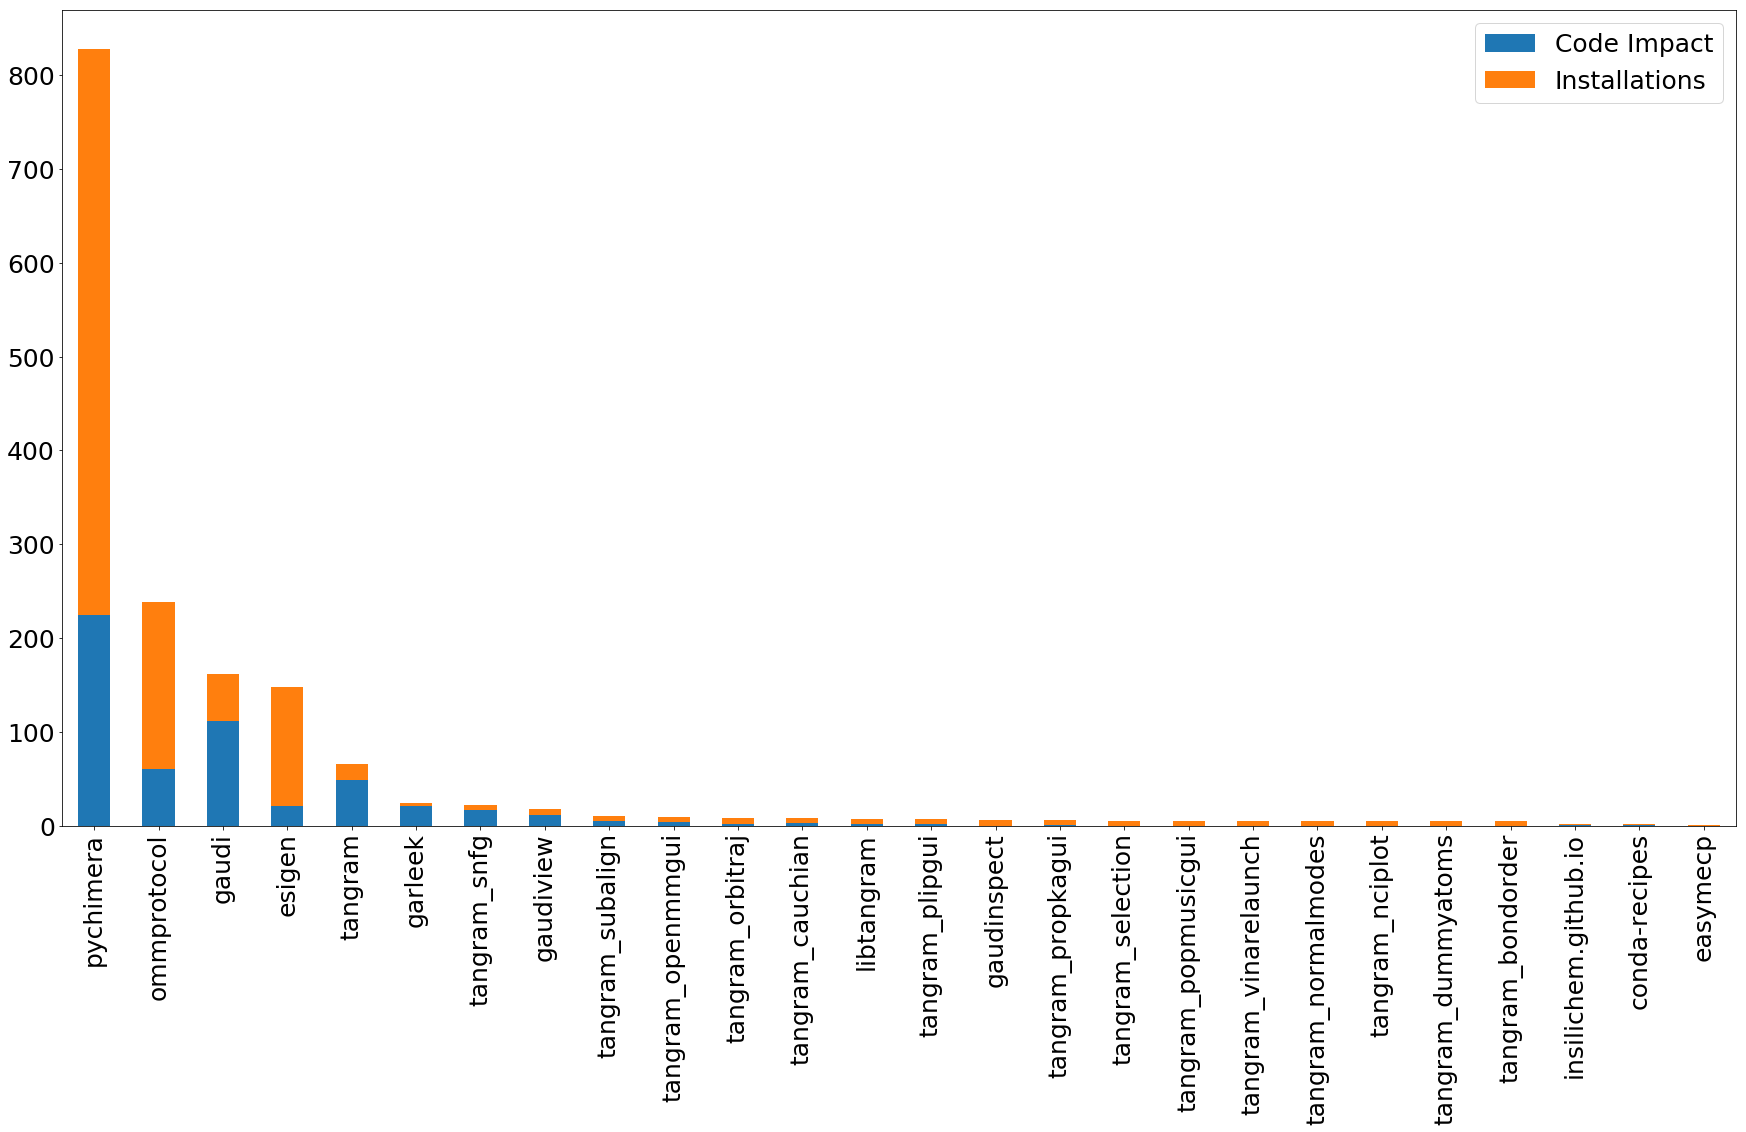

In [53]:
p = df.drop('sum', axis=1).plot.bar(figsize=(30,15), fontsize=25, stacked=True)
p.legend(fontsize=25)
p

In [5]:
df = pd.DataFrame()
df.to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n    </tr>\n  </thead>\n  <tbody>\n  </tbody>\n</table>'